In [12]:
import torch
import time
import os
import numpy as np
from models.networks import NGP
from models.rendering import render
from metrics import psnr
from einops import repeat
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import dataset_dict
from datasets.ray_utils import get_ray_directions, get_rays
from utils import load_ckpt
import cc3d
import imageio

dataset_name = 'mgtv'
scene = 'F1_06'
take = '000720'
dataset = dataset_dict[dataset_name](
    '/home/ubuntu/hdd/data/mgtv', scene=scene, take=take,
    split='test', downsample=1.0/2)

# train one GAN per scene
# bad scenes (bounding box) F1_06: 720 990 1005
# M1_02: 48
# M2_03: 180, 186, 187

Loading 0 test images ...


0it [00:00, ?it/s]


In [1]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("/home/ubuntu/Videos/21.mp4")
clip2 = VideoFileClip("/home/ubuntu/Videos/22.mp4")
clip3 = VideoFileClip("/home/ubuntu/Videos/23.mp4")
clip4 = VideoFileClip("/home/ubuntu/Videos/24.mp4")
final_clip = concatenate_videoclips([clip1,clip2,clip3,clip4])
final_clip.write_videofile("/home/ubuntu/Videos/cuda4.mp4")

Moviepy - Building video /home/ubuntu/Videos/cuda4.mp4.
MoviePy - Writing audio in cuda4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/ubuntu/Videos/cuda4.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu/Videos/cuda4.mp4


In [13]:
model = NGP(scale=0.5, use_a=scene[0]=='F').cuda()
load_ckpt(model, f'ckpts/{dataset_name}/{scene}/{take}/epoch=19_slim.ckpt')

from kornia.utils.grid import create_meshgrid3d
import vren

G = model.grid_size
xyz = create_meshgrid3d(G, G, G, False, dtype=torch.int32).reshape(-1, 3)
indices = vren.morton3D(xyz.cuda()).long().cpu().numpy()

_density_bitfield = model.density_bitfield

density_bitfield = torch.zeros(model.cascades*G**3//8, 8, dtype=torch.bool)
for i in range(8):
    density_bitfield[:, i] = _density_bitfield & torch.tensor([2**i], device='cuda')
density_bitfield = density_bitfield.reshape(model.cascades, G**3).cpu().numpy()

largest_connected_components = \
    cc3d.largest_k(density_bitfield[0, indices].reshape(G, G, G),
                   k=2 if scene=='M3_02' else 1, connectivity=6)
new_density_grid = torch.zeros(model.cascades, G**3, device='cuda')
new_density_grid[0, indices] = \
    torch.cuda.FloatTensor(largest_connected_components.reshape(model.cascades, -1).astype(np.float32))

# update
vren.packbits(new_density_grid, 0.5, model.density_bitfield)

_density_bitfield = model.density_bitfield
density_bitfield = torch.zeros(model.cascades*G**3//8, 8, dtype=torch.bool)
for i in range(8):
    density_bitfield[:, i] = _density_bitfield & torch.tensor([2**i], device='cuda')
density_bitfield = density_bitfield.reshape(model.cascades, G**3).cpu()

GridEncoding: Nmin=16 b=1.31951 F=2 T=2^19 L=16


/home/ubuntu/anaconda3/envs/volsdf/lib/python3.8/site-packages/torch/functional.py:568: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)



In [ ]:
with open('/home/ubuntu/hdd/data/mgtv/evaluation_code/val_rect.txt', 'r') as f:
    lines = f.readlines()
    
crop_dict = {}
for line in lines:
    filename, x, y, w, h = line.split()
    scene_, take_, filename_ = filename.split('/')
    if scene_==scene and take_==take[:6]:
        cam = int(filename_[9:11])-1
        crop_dict[cam] = (int(x)//2, int(y)//2, int(w)//2, int(h)//2)

In [4]:
psnrs = []; ts = []
os.makedirs(f'results/{dataset_name}/{scene}/{take}', exist_ok=True)

for cam in tqdm(range(92)):
    directions = get_ray_directions(dataset.Hs[cam], dataset.Ws[cam], dataset.Ks[cam], flatten=False)
    if cam in crop_dict:
        x, y, w, h = crop_dict[cam]
        directions = directions[y:y+h, x:x+w]
    else:
        continue
#         w = dataset.Ws[cam]
#         h = dataset.Hs[cam]
    directions = directions.reshape(-1, 3)
    rays_o, rays_d = get_rays(directions.cuda(), dataset.poses[cam].cuda())
    
    # TODO: use chunk...
    results = render(model, rays_o, rays_d, 
                     **{'test_time': True, 'cam': torch.cuda.LongTensor([0])})
    pred = results['rgb'].reshape(h, w, 3).cpu().numpy()
    pred = (pred*255).astype(np.uint8)
    imageio.imwrite(f'results/{dataset_name}/{scene}/{take}/image.cam{cam+1:02d}_{take}.jpg', pred)
    
    torch.cuda.empty_cache()

  0%|          | 0/92 [00:00<?, ?it/s]

mean time: 0.0781 s, FPS: 12.80
mean samples per ray: 20.40


RuntimeError: shape '[1248, 352, 3]' is invalid for input of size 2016000

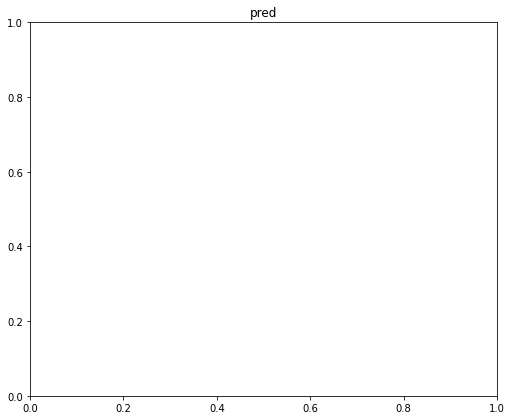

In [5]:
plt.subplots(figsize=(15, 12))
plt.tight_layout()
plt.subplot(221)
plt.title('pred')
pred = results['rgb'].reshape(h, w, 3).cpu().numpy()
plt.imshow(pred)
plt.subplot(222)
plt.title('depth')
depth = results['depth'].reshape(h, w).cpu().numpy()
depth_ = depth2img(depth)
plt.imshow(depth_)
plt.subplot(223)
plt.title('opacity')
plt.imshow(results['opacity'].reshape(h, w).cpu().numpy(), 'bone')
plt.show()

In [14]:
from plyfile import PlyData, PlyElement
import mcubes

N = 128
chunk = 128**3
sigma_threshold = 1
x = np.linspace(-0.5, 0.5, N)
y = np.linspace(-0.5, 0.5, N)
z = np.linspace(-0.5, 0.5, N)

xyz = torch.FloatTensor(np.stack(np.meshgrid(x, y, z), -1).reshape(-1, 3))

sigma_chunks = []
with torch.no_grad():
    for i in range(0, xyz.shape[0], chunk):
        sigma_chunks += [model.density(xyz[i:i+chunk].cuda()).cpu().numpy()]
sigma = np.concatenate(sigma_chunks).reshape(N, N, N).astype(np.float32)
sigma = cc3d.largest_k(sigma>sigma_threshold, k=2 if scene=='M3_02' else 1, connectivity=6)

vertices, triangles = mcubes.marching_cubes(sigma, 0.5)
# mesh = trimesh.Trimesh(vertices, triangles)
# mesh.show()

vertices = (vertices/N).astype(np.float32)
vertices[:, :2] = vertices[:, [1, 0]]-0.5
vertices[:, 2] += -0.5

# vertices_ = vertices.copy()
# vertices_.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4')]
# face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
# face['vertex_indices'] = triangles

# PlyData([PlyElement.describe(vertices_[:, 0], 'vertex'), 
#          PlyElement.describe(face, 'face')]).write(f'{scene}_{take}.ply')

In [16]:
from datasets.ray_utils import get_rays
import plotly.graph_objects as go
from collections import defaultdict
import cc3d

fig = go.Figure()

# cameras
for ip in range(len(dataset.poses)):
    K = dataset.Ks[ip]
    img_wh = (dataset.Ws[ip], dataset.Hs[ip])
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    u = torch.FloatTensor([0, img_wh[0]-1, img_wh[0]-1, 0])
    v = torch.FloatTensor([0, 0, img_wh[1]-1, img_wh[1]-1])
    ds = torch.stack([(u-cx+0.5)/fx, (v-cy+0.5)/fy, torch.ones_like(u)], -1)
    o, d = get_rays(ds, torch.FloatTensor(dataset.poses[ip]))
    o = o.numpy(); d = d.numpy()/10
    od = o+d
    xlines = [od[0, 0], od[1, 0], od[2, 0], od[3, 0], od[0, 0], None]
    ylines = [od[0, 1], od[1, 1], od[2, 1], od[3, 1], od[0, 1], None]
    zlines = [od[0, 2], od[1, 2], od[2, 2], od[3, 2], od[0, 2], None]
    for i in range(4):
        xlines += [o[i, 0], od[i, 0], None]
        ylines += [o[i, 1], od[i, 1], None]
        zlines += [o[i, 2], od[i, 2], None]
    fig.add_trace(
        go.Scatter3d(
            x=xlines,
            y=ylines,
            z=zlines,
            mode='lines',
            name=f'camera {ip+1}',
            marker=dict(size=1, color='black')
        )
    )

try:
    fig.add_trace(
        go.Scatter3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            mode='markers',
            name='scene pts',
            marker=dict(size=0.4, color='red'),
        )
    )
except: pass


for ca in range(model.cascades):
    s = min(2**(ca-1), model.scale)
    xlines = [s, s, s, s, s, None, -s, -s, -s, -s, -s, None]
    ylines = [-s, -s, s, s, -s, None, -s, -s, s, s, -s, None]
    zlines = [s, -s, -s, s, s, None, s, -s, -s, s, s, None]
    xlines += [s, -s, None, s, -s, None, s, -s, None, s, -s, None]
    ylines += [-s, -s, None, -s, -s, None, s, s, None, s, s, None]
    zlines += [s, s, None, -s, -s, None, -s, -s, None, s, s, None]
    fig.add_trace(
        go.Scatter3d(
            x=xlines,
            y=ylines,
            z=zlines,
            mode='lines',
            name=f'bbox {ca}',
            marker=dict(size=1, color='orange')
        )
    )

# try:
#     m = defaultdict(list)
#     cube_colors = ['lightgray', 'lightcyan', 'magenta']
#     for ca in range(model.cascades):
#         if ca>0: break
#         s = min(2**(ca-1), model.scale)
#         xyz_ = xyz[density_bitfield[ca, indices]]
#         if len(xyz_)==0: continue
#         for i in tqdm(range(len(xyz_))):
#             hs = s/model.grid_size
#             c = (xyz_[i].numpy()/(model.grid_size-1)*2-1)*(s-hs)
#             m['x'] += [(np.array([0, 0, 1, 1, 0, 0, 1, 1])-0.5)*2*hs+c[0]]
#             m['y'] += [(np.array([0, 1, 1, 0, 0, 1, 1, 0])-0.5)*2*hs+c[1]]
#             m['z'] += [(np.array([0, 0, 0, 0, 1, 1, 1, 1])-0.5)*2*hs+c[2]]
#             m['i'] += [np.array([7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2])+len(m['i'])*8]
#             m['j'] += [np.array([3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3])+len(m['j'])*8]
#             m['k'] += [np.array([0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6])+len(m['k'])*8]
#         fig.add_trace(
#             go.Mesh3d(
#                 x=np.concatenate(m['x']),
#                 y=np.concatenate(m['y']),
#                 z=np.concatenate(m['z']),
#                 i=np.concatenate(m['i']),
#                 j=np.concatenate(m['j']),
#                 k=np.concatenate(m['k']),
#                 color=cube_colors[ca],
#                 name=f'occupied cells {ca}',
#                 showlegend=True,
#                 opacity=0.4**(ca+1)
#             )
#         )
# except: pass

layout = go.Layout(scene=dict(aspectmode='data'), dragmode='orbit')
fig.update_layout(layout)

fig.show()